# Introducing CivisML 2.0
CivisML 2.0 is full of new features to make modeling faster, more accurate, and more portable. CivisML can be used to build models that answer all kinds of business questions, such as what movie to recommend to a customer, or which customers are most likely to upgrade their accounts. For the sake of example, this notebook uses a publicly available dataset on US colleges, and focuses on predicting the type of college (public non-profit, private non-profit, or private for-profit).

This notebook will cover the following topics:
- CivisML overview
- use of the new ETL transformer, `DataFrameETL`, for easy, customizable ETL
- stacked models: combine models to get one bigger, better model
- model portability: get trained models out of CivisML
- multilayer perceptron models: neural networks built in to CivisML
- hyperband: a smarter alternative to grid search

In [1]:
# first, let's import the packages we need
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection

import civis
from civis.ml import ModelPipeline

import warnings
warnings.filterwarnings('ignore')

## Downloading data
Before we build any models, we need a dataset to play with. We're going to use the most recent College Scorecard data from the Department of Education.

This dataset is collected to study the performance of US higher education institutions. You can learn more about it in [this technical paper](https://collegescorecard.ed.gov/assets/UsingFederalDataToMeasureAndImprovePerformance.pdf), and you can find details on the dataset features in [this data dictionary](https://collegescorecard.ed.gov/data/).

In [2]:
# Downloading data; this may take a minute
r = requests.get("https://ed-public-download.app.cloud.gov/downloads/Most-Recent-Cohorts-All-Data-Elements.csv")
# cutting off the first few characters, which are not part of the csv
df_io = StringIO(r.text[3:])
# Two kind of nulls
df = pd.read_csv(df_io, sep=",", na_values=['NULL', 'PrivacySuppressed'])

In [3]:
# How many rows and columns?
df.shape

(7593, 1805)

In [4]:
# What are some of the column names?
df.columns

Index(['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP',
       'ACCREDAGENCY', 'INSTURL', 'NPCURL',
       ...
       'OMENRYP8_FTNFT', 'OMENRAP8_FTNFT', 'OMENRUP8_FTNFT', 'OMACHT6_PTNFT',
       'OMAWDP6_PTNFT', 'OMACHT8_PTNFT', 'OMAWDP8_PTNFT', 'OMENRYP8_PTNFT',
       'OMENRAP8_PTNFT', 'OMENRUP8_PTNFT'],
      dtype='object', length=1805)

## Data Munging
Before running CivisML, we need to do some basic data munging, such as removing missing data from the dependent variable, and splitting the data into training and test sets.

Throughout this notebook, we'll be trying to predict whether a college is public (labelled as 1), private non-profit (2), or private for-profit (3). The column name for this dependent variable is "CONTROL".

In [5]:
# Make sure to remove any rows with nulls in the dependent variable
df = df[np.isfinite(df['CONTROL'])]

In [6]:
# split into training and test sets
train_data, test_data = model_selection.train_test_split(df, test_size=0.2)

In [7]:
# print a few sample columns
train_data.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMENRYP8_FTNFT,OMENRAP8_FTNFT,OMENRUP8_FTNFT,OMACHT6_PTNFT,OMAWDP6_PTNFT,OMACHT8_PTNFT,OMAWDP8_PTNFT,OMENRYP8_PTNFT,OMENRAP8_PTNFT,OMENRUP8_PTNFT
5270,441690,3531300,35313,Universidad Pentecostal Mizpa,Rio Piedras,PR,00928,Association for Bibical Higher Educaiton,mizpa.edu,mizpa.edu/netprice/npcalc.htm,...,0.0,0.0000,0.5882,23.0,0.2609,23.0,0.2609,0.0435,0.000,0.6957
2175,184205,260100,2601,Cumberland County College,Vineland,NJ,08362-1500,Middle States Commission on Higher Education,www.cccnj.edu,www.cccnj.edu/netPrice/index.html,...,0.0,0.5484,0.2258,40.0,0.4500,40.0,0.5250,0.0250,0.275,0.1750
2642,198941,647800,6478,Mercy School of Nursing,Charlotte,NC,28203,Accreditation Commission for Education in Nursing,www.carolinashealthcare.org/MSON,www.carolinashealthcare.org/MSON,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4263,261676,2339700,23397,Ross Medical Education Center-Brighton,Brighton,MI,48116,Accrediting Bureau of Health Education Schools,www.rosseducation.edu,www.rosseducation.edu,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4397,369084,10732908,7329,ITT Technical Institute-Albuquerque,Albuquerque,NM,87109,NaN,www.itt-tech.edu,www.itt-tech.edu/npc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some of these columns are duplicates, or contain information we don't want to use in our model (like college names and URLs). CivisML can take a list of columns to exclude and do this part of the data munging for us, so let's make that list here.

In [8]:
to_exclude = ['ADM_RATE_ALL', 'OPEID', 'OPEID6', 'ZIP', 'INSTNM', 
              'INSTURL', 'NPCURL', 'ACCREDAGENCY', 'T4APPROVALDATE', 
              'STABBR', 'ALIAS', 'REPAY_DT_MDN', 'SEPAR_DT_MDN']

## Basic CivisML Usage
When building a supervised model, there are a few basic things you'll probably want to do:

1. Transform the data into a modelling-friendly format
2. Train the model on some labelled data
3. Validate the model
4. Use the model to make predictions about unlabelled data

CivisML does all of this in three lines of code. Let's fit a basic sparse logistic model to see how.

The first thing we need to do is build a `ModelPipeline` object. This stores all of the basic configuration options for the model. We'll tell it things like the type of model, dependent variable, and columns we want to exclude. CivisML handles basic ETL for you, including categorical expansion of any string-type columns.

In [9]:
# Use a push-button workflow to fit a model with reasonable default parameters
sl_model = ModelPipeline(model='sparse_logistic',
                         model_name='Example sparse logistic',
                         primary_key='UNITID',
                         dependent_variable=['CONTROL'],
                         excluded_columns=to_exclude)

Next, we want to train and validate the model by calling `.train` on the `ModelPipeline` object. CivisML uses 4-fold cross-validation on the training set. You can train on local data or query data from Redshift. In this case, we have our data locally, so we just pass the data frame.

In [10]:
sl_train = sl_model.train(train_data)

This returns a `ModelFuture` object, which is *non-blocking*-- this means that you can keep doing things in your notebook while the model runs on Civis Platform in the background. If you want to make a blocking call (one that doesn't complete until your model is finished), you can use `.result()`.

In [11]:
# non-blocking
sl_train

<ModelFuture at 0x7f293cf39eb8 state=running>

In [12]:
# blocking
sl_train.result()

{'container_id': 9137792,
 'error': None,
 'finished_at': '2018-01-17T21:25:08.000Z',
 'id': 69726571,
 'is_cancel_requested': False,
 'started_at': '2018-01-17T21:18:48.000Z',
 'state': 'succeeded'}

We can see how well the model did by looking at the validation metrics.

In [13]:
# loop through the metric names and print to screen
metrics = [print(key) for key in sl_train.metrics.keys()]

accuracy
confusion_matrix
p_correct
pop_incidence_true
pop_incidence_pred
roc_auc
log_loss
brier_score
deciles
roc_curve_by_class
calibration_curve_by_class
roc_auc_macroavg
score_histogram
training_histogram
oos_score_table


In [14]:
# ROC AUC for each of the three categories in our dependent variable
sl_train.metrics['roc_auc']

[0.9963479457451291, 0.9413246335261132, 0.9602249988203488]

Not bad!

This is the basic CivisML workflow: create the model, train, and make predictions. There are other configuration options for more complex use cases; for example, you can create a custom estimator, pass custom dependencies, manage the computing resources for larger models, and more. For more information, see the Machine Learning section of the [Python API client docs](https://civis-python.readthedocs.io).

Now that we can build a simple model, let's see what's new to version 2.0!

## Custom ETL
CivisML does a lot of data munging for you:
- categorical expansion
- dropping columns
- removing null columns

With 2.0, you can now recreate and customize this ETL using `DataFrameETL`, our open source ETL transformer, [available on GitHub](https://github.com/civisanalytics/civisml-extensions).

By default, CivisML will use DataFrameETL to automatically detect non-numeric columns for categorical expansion. Our example dataset has a lot of integer columns which are actually categorical, but we can make sure they're handled correctly by passing CivisML a custom ETL transformer.

In [15]:
# The ETL transformer used in CivisML can be found in the civismlext module
from civismlext.preprocessing import DataFrameETL

This creates a list of columns to categorically expand, identified using the data dictionary available [here](https://collegescorecard.ed.gov/data/).

In [16]:
# column indices for columns to expand
to_expand = list(df.columns[:21]) + list(df.columns[23:36]) + list(df.columns[99:290]) + \
    list(df.columns[[1738, 1773, 1776]])

In [17]:
# create ETL estimator to pass to CivisML
etl = DataFrameETL(cols_to_drop=to_exclude, 
                   cols_to_expand=to_expand, # we made this column list during data munging
                   check_null_cols='warn')

You can also use this estimator for ETL outside of Civis Platform. Here's an example of how to transform your own data locally.

In [18]:
%%time
# The default output format is a numpy array of float32s. This makes ETL fast!
etl.fit_transform(train_data.head()).shape

CPU times: user 560 ms, sys: 44 ms, total: 604 ms
Wall time: 735 ms


(5, 1862)

## Model Stacking
Now it's time to fit a model. Let's take a look at model stacking, which is new to CivisML 2.0.

Stacking lets you combine several algorithms into a single model which performs as well or better! In CivisML, we have two stacking workflows: `stacking_classifier` (sparse logistic, GBT, and random forest, with a logistic regression model as a "meta-estimator" to combine predictions from the other models); and `stacking_regressor` (sparse linear, GBT, and random forest, with a non-negative linear regression as the meta-estimator). Use them the same way you use `sparse_logistic` or other pre-defined models.

Let's fit both a stacking classifier and some un-stacked models, so we can compare the performance.

In [19]:
workflows = ['stacking_classifier',
            'sparse_logistic',
            'random_forest_classifier',
            'gradient_boosting_classifier']
models = []
# create a model object for each of the four model types
for wf in workflows:
    model = ModelPipeline(model=wf,
                          model_name=wf + ' 2.0 example',
                          primary_key='UNITID',
                          dependent_variable=['CONTROL'],
                          etl=etl  # use the custom ETL we created
                          )
    models.append(model)

In [20]:
# iterate over the model objects and run a CivisML training job for each
trains = []
for model in models:
    train = model.train(train_data)
    trains.append(train)

Let's plot the ROC curves and AUCs for each model. In the Civis Platform, these plots will automatically be built and displayed in the "models" tab. But for the sake of example, let's plot them here in the notebook.

There are three classes (public, non-profit private, and for-profit private), so we'll have three curves per model. It looks like all of the models are doing well, with sparse logistic performing slightly worse.

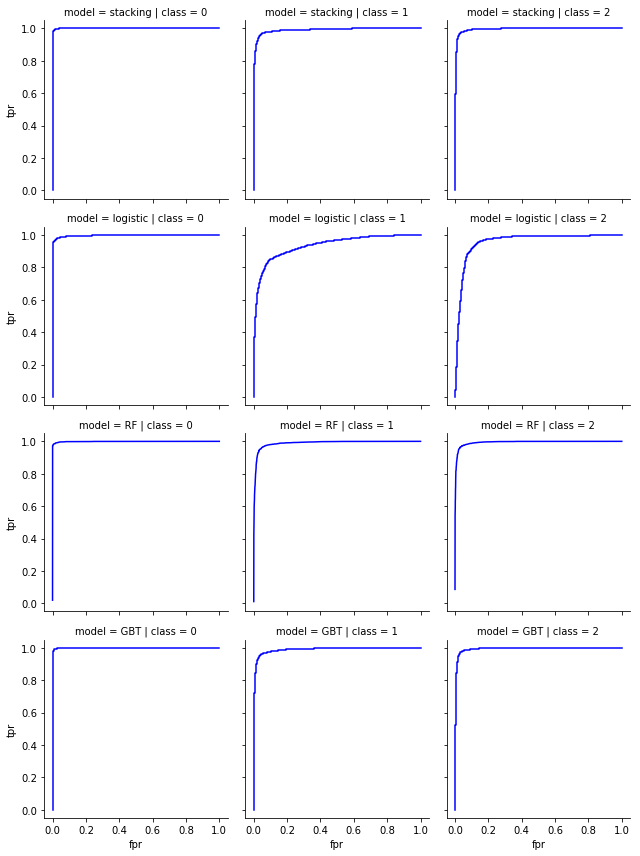

In [21]:
%matplotlib inline
# Let's look at how the model performed during validation
def extract_roc(fut_job, model_name):
    '''Build a data frame of ROC curve data from the completed training job `fut_job`
    with model name `model_name`. Note that this function will only work for a classification
    model where the dependent variable has more than two classes.'''
    aucs = fut_job.metrics['roc_auc']
    roc_curve = fut_job.metrics['roc_curve_by_class']
    n_classes = len(roc_curve)
    fpr = []
    tpr = []
    class_num = []
    auc = []
    for i, curve in enumerate(roc_curve):
        fpr.extend(curve['fpr'])
        tpr.extend(curve['tpr'])
        class_num.extend([i] * len(curve['fpr']))
        auc.extend([aucs[i]] * len(curve['fpr']))
    model_vec = [model_name] * len(fpr)
    df = pd.DataFrame({
        'model': model_vec,
        'class': class_num,
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc
    })
    return df

# extract ROC curve information for all of the trained models
workflows_abbrev = ['stacking', 'logistic', 'RF', 'GBT']
roc_dfs = [extract_roc(train, w) for train, w in zip(trains, workflows_abbrev)]
roc_df = pd.concat(roc_dfs)

# create faceted ROC curve plots. Each row of plots is a different model type, and each
# column of plots is a different class of the dependent variable.
g = sns.FacetGrid(roc_df, col="class",  row="model")
g = g.map(plt.plot, "fpr", "tpr", color='blue')

All of the models perform quite well, so it's difficult to compare based on the ROC curves. Let's plot the AUCs themselves.

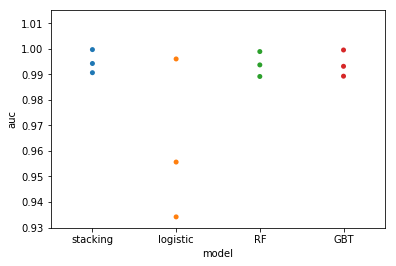

In [22]:
# Plot AUCs for each model
%matplotlib inline
auc_df = roc_df[['model', 'class', 'auc']]
auc_df.drop_duplicates(inplace=True)
plt.show(sns.swarmplot(x=auc_df['model'], y=auc_df['auc']))

Here we can see that all models but sparse logistic perform quite well, but stacking appears to perform marginally better than the others. For more challenging modeling tasks, the difference between stacking and other models will often be more pronounced.

Now we can use these models to predict out-of-sample data. Let's see if their predictions are similar.

In [23]:
# kick off a prediction job for each of the four models
preds = [model.predict(test_data) for model in models]

In [24]:
# May run for a minute while the jobs run
[pred.result() for pred in preds]

[{'container_id': 9138218,
  'error': None,
  'finished_at': '2018-01-17T21:44:07.000Z',
  'id': 69728304,
  'is_cancel_requested': False,
  'started_at': '2018-01-17T21:43:26.000Z',
  'state': 'succeeded'},
 {'container_id': 9138220,
  'error': None,
  'finished_at': '2018-01-17T21:44:10.000Z',
  'id': 69728306,
  'is_cancel_requested': False,
  'started_at': '2018-01-17T21:43:32.000Z',
  'state': 'succeeded'},
 {'container_id': 9138222,
  'error': None,
  'finished_at': '2018-01-17T21:44:08.000Z',
  'id': 69728308,
  'is_cancel_requested': False,
  'started_at': '2018-01-17T21:43:36.000Z',
  'state': 'succeeded'},
 {'container_id': 9138229,
  'error': None,
  'finished_at': '2018-01-17T21:44:11.000Z',
  'id': 69728315,
  'is_cancel_requested': False,
  'started_at': '2018-01-17T21:43:41.000Z',
  'state': 'succeeded'}]

In [25]:
# print the top few rows for each of the models
pred_df = [pred.table.head() for pred in preds]
import pprint
pprint.pprint(pred_df)

[          control_1  control_2  control_3
UNITID                                   
217882     0.993129   0.006856   0.000015
195234     0.001592   0.990423   0.007985
446385     0.002784   0.245300   0.751916
13508115   0.003109   0.906107   0.090785
459499     0.005351   0.039922   0.954726,
              control_1  control_2  control_3
UNITID                                      
217882    9.954234e-01   0.000200   0.004377
195234    6.766601e-08   0.999615   0.000385
446385    4.571749e-03   0.056303   0.939125
13508115  1.768058e-02   0.699806   0.282514
459499    1.319468e-02   0.285295   0.701510,
           control_1  control_2  control_3
UNITID                                   
217882        0.960      0.034      0.006
195234        0.012      0.974      0.014
446385        0.020      0.508      0.472
13508115      0.006      0.914      0.080
459499        0.032      0.060      0.908,
           control_1  control_2  control_3
UNITID                                   
217882

Looks like the probabilities here aren't exactly the same, but are directionally identical-- so, if you chose the class that had the highest probability for each row, you'd end up with the same predictions for all models. This makes sense, because all of the models performed well.

## Model Portability
What if you want to score a model outside of Civis Platform? Maybe you want to deploy this model in an app for education policy makers. In CivisML 2.0, you can easily get the trained model out of the `ModelFuture` object.

In [26]:
train_stack = trains[0] # Get the ModelFuture for the stacking model
trained_model = train_stack.estimator

This `Pipeline` contains all of the steps CivisML used to train the model, from ETL to the model itself. We can print each step individually to get a better sense of what is going on.

In [27]:
# print each of the estimators in the pipeline, separated by newlines for readability
for step in train_stack.estimator.steps:
    print(step[1])
    print('\n')

DataFrameETL(check_null_cols='warn',
       cols_to_drop=['ADM_RATE_ALL', 'OPEID', 'OPEID6', 'ZIP', 'INSTNM', 'INSTURL', 'NPCURL', 'ACCREDAGENCY', 'T4APPROVALDATE', 'STABBR', 'ALIAS', 'REPAY_DT_MDN', 'SEPAR_DT_MDN'],
       cols_to_expand=['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP', 'ACCREDAGENCY', 'INSTURL', 'NPCURL', 'SCH_DEG', 'HCM2', 'MAIN', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL', 'ST_FIPS', 'REGION', 'LOCALE', 'LOCALE2', 'CCBASIC', 'CCUGPROF', 'CCSIZSET', 'HBCU', 'PBI', 'ANNHI', 'TRIBAL',...RT2', 'CIP54ASSOC', 'CIP54CERT4', 'CIP54BACHL', 'DISTANCEONLY', 'ICLEVEL', 'OPENADMP', 'ACCREDCODE'],
       dataframe_output=False, dummy_na=True, fill_value=0.0)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)


StackedClassifier(cv=StratifiedKFold(n_splits=4, random_state=42420, shuffle=True),
         estimator_list=[('sparse_logistic', Pipeline(memory=None,
     steps=[('selectfrommodel', SelectFromModel(estimator=LogitNet(alpha=1, c

Now we can see that there are three steps: the `DataFrameETL` object we passed in, a null imputation step, and the stacking estimator itself.

We can use this outside of CivisML simply by calling `.predict` on the estimator. This will make predictions using the model in the notebook without using CivisML.

In [28]:
# drop the dependent variable so we don't use it to predict itself!
predictions = trained_model.predict(test_data.drop(labels=['CONTROL'], axis=1))

In [29]:
# print out the class predictions. These will be integers representing the predicted
# class rather than probabilities.
predictions

array([1, 2, 3, ..., 3, 2, 2])

## Hyperparameter optimization with Hyperband and Neural Networks
Multilayer Perceptrons (MLPs) are simple neural networks, which are now built in to CivisML. The MLP estimators in CivisML come from [muffnn](https://github.com/civisanalytics/muffnn), another open source package written and maintained by Civis Analytics. Let's fit one using hyperband.

Hyperband is an alternative to grid search for hyperparameter optimization (learn about the details in [this paper](https://arxiv.org/abs/1603.06560)). Grid search runs every parameter combination for the full time, while hyperband runs many combinations for a short time, then filters out the best, runs them for longer, filters again, and so on. This means that you can try more combinations in less time, so it's recommended to use it where possible. The hyperband estimator is open source and [available on GitHub](https://github.com/civisanalytics/civisml-extensions).

Right now, it's implemented in CivisML named preset models for the following algorithms: 
- Multilayer Perceptrons (MLPs)
- random forests
- GBTs
- ExtraTrees. 

Unlike grid search, you don't need to specify values to search over. If you pass `cross_validation_parameters='hyperband'` to `ModelPipeline`, hyperparameter combinations will be randomly drawn from preset distributions.

In [30]:
# build a model specifying the MLP model with hyperband
model_mlp = ModelPipeline(model='multilayer_perceptron_classifier',
                          model_name='MLP example',
                          primary_key='UNITID',
                          dependent_variable=['CONTROL'],
                          cross_validation_parameters='hyperband',
                          etl=etl
                          )
train_mlp = model_mlp.train(train_data, 
                            n_jobs=10) # parallel hyperparameter optimization and validation!
# block until the job finishes
train_mlp.result()

{'container_id': 9138258,
 'error': None,
 'finished_at': '2018-01-17T22:11:21.000Z',
 'id': 69728426,
 'is_cancel_requested': False,
 'started_at': '2018-01-17T21:44:33.000Z',
 'state': 'succeeded'}

### Parallel Model Tuning and Validation
Another new feature in CivisML 2.0 is parallel model tuning and validation. This means that parameter configurations and cross-validation folds will be run in parallel. In the example above, I specified 10 as the maximum number of jobs, to make this explicit. But you don't have to specify `n_jobs`-- by default, CivisML will give you as many resources as it can without taking over your computing cluster. This is also true for parallel model scoring, which has been available since CivisML 1.0.

Like the stacking model, this model starts with ETL and null imputation, but contains some additional steps: a step to scale the predictor variables (which improves neural network performance), and a hyperband searcher containing the MLP.

In [31]:
for step in train_mlp.estimator.steps:
    print(step[1])
    print('\n')

INFO:tensorflow:Restoring parameters from /tmp/tmpe49np0dv/saved_model
DataFrameETL(check_null_cols='warn',
       cols_to_drop=['ADM_RATE_ALL', 'OPEID', 'OPEID6', 'ZIP', 'INSTNM', 'INSTURL', 'NPCURL', 'ACCREDAGENCY', 'T4APPROVALDATE', 'STABBR', 'ALIAS', 'REPAY_DT_MDN', 'SEPAR_DT_MDN'],
       cols_to_expand=['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP', 'ACCREDAGENCY', 'INSTURL', 'NPCURL', 'SCH_DEG', 'HCM2', 'MAIN', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL', 'ST_FIPS', 'REGION', 'LOCALE', 'LOCALE2', 'CCBASIC', 'CCUGPROF', 'CCSIZSET', 'HBCU', 'PBI', 'ANNHI', 'TRIBAL',...RT2', 'CIP54ASSOC', 'CIP54CERT4', 'CIP54BACHL', 'DISTANCEONLY', 'ICLEVEL', 'OPENADMP', 'ACCREDCODE'],
       dataframe_output=False, dummy_na=True, fill_value=0.0)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)


MinMaxScaler(copy=False, feature_range=(0, 1))


HyperbandSearchCV(cost_parameter_max={'n_epochs': 50},
         cost_parameter_min={'n_epochs': 5}, cv=None,

The `best_estimator_` attribute of HyperbandSearchCV gives you the optimized estimator, just like GridSearchCV.

In [32]:
train_mlp.estimator.steps[3][1].best_estimator_

MLPClassifier(activation=<function relu at 0x7f28a5746510>, batch_size=64,
       hidden_units=(128, 128), init_scale=0.1,
       keep_prob=0.83244264080042174, n_epochs=45, random_state=None,
       solver=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       solver_kwargs={'learning_rate': 0.002})

In [33]:
# the score of the best-scoring model
train_mlp.estimator.steps[3][1].best_score_

0.94616397760948301

In [34]:
# some metrics and metadata for the different hyperparameter configurations
train_mlp.estimator.steps[3][1].cv_results_

{'mean_fit_time': array([  5.71521004,   9.87880683,   7.02491919,   2.49734783,
          2.04555511,   3.0459307 ,   1.41299955,   1.03468744,
          8.28476421,  13.8823324 ,  17.15766454,   5.7730906 ,
          6.91940331,   5.92865777,  55.33232911,  13.65520374,
         49.46581841,   7.73342903,  10.29447095,   2.70951978,
         17.35557111,  33.21902045]),
 'mean_score_time': array([ 0.12489303,  0.25389655,  0.11093688,  0.08840664,  0.0935638 ,
         0.11657325,  0.07519325,  0.06182806,  0.2851553 ,  0.15998785,
         0.2072041 ,  0.09375119,  0.11130897,  0.1001962 ,  0.22202452,
         0.09535344,  0.1758012 ,  0.1068356 ,  0.13764652,  0.05892269,
         0.10381524,  0.14680648]),
 'mean_test_score': array([ 0.89924267,  0.45702996,  0.45702996,  0.87471189,  0.45702996,
         0.91307211,  0.72275272,  0.88508396,  0.55021403,  0.45702996,
         0.88162661,  0.93233454,  0.54050049,  0.74349687,  0.91126111,
         0.92920645,  0.45702996,  0.921

In [35]:
# we can use this model to make predictions, in the same way as the other models
predict_mlp = model_mlp.predict(test_data)

In [36]:
predict_mlp.table.head()

,control_1,control_2,control_3
UNITID,,,
217882,9.999834e-01,0.000016,4.727007e-07
195234,1.779818e-03,0.996192,2.028217e-03
446385,8.158081e-07,0.005291,9.947079e-01
13508115,1.671655e-02,0.972799,1.048439e-02
459499,4.405403e-03,0.035383,9.602115e-01


We're excited to see what problems you solve with these new capabilities. If you have any problems or questions, contact us at support@civisanalytics.com. Happy modeling!